In [408]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
import os

In [409]:
from brian2 import *
from brian2tools import *

import matplotlib.pyplot as plt
import scipy

import cx_rate
import trials
import plotter
import bee_simulator

from cx_spiking.constants import *

import cx_spiking.plotting
import cx_spiking.inputs
import cx_spiking.network_creation as nc

In [410]:
######################################
### INPUTS
######################################
route_file = os.path.join(os.environ.get('MSC_PROJECT'), 'notebooks/data/route.npz')
T_outbound = 1500
T_inbound = 1500
T = T_outbound+T_inbound

h, v, = cx_spiking.inputs.generate_route(T_outbound=1500, vary_speed=True, route_file=route_file, load_route=True)

cx_spiking.inputs.save_route(route_file, h, v, save_route=False)

# Convert headings
headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
headings = np.tile(headings, 2)
headings = np.concatenate((headings, np.zeros((T_inbound, headings.shape[1]))), axis=0)
#headings[:,:8] = 100
#headings[:,8:] = 0

# Convert velocity into optical flow
flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)
flow = np.concatenate((flow, np.zeros((T_inbound, flow.shape[1]))), axis=0)
#flow[:,0] = 100
#flow[:,1] = 0


######################################
### RATE BASED CX
######################################
noise = 0.1
cx = cx_rate.CXRatePontin(noise=noise)

h, v, cx_log, cpu4_snapshot = trials.run_trial(logging=True,
                                               T_outbound=T_outbound,
                                               T_inbound=T_inbound,
                                               noise=noise,
                                               cx=cx,
                                               route=(h[:T_outbound], v[:T_outbound]))

# headings = cx_spiking.inputs.compute_headings(h, N=N_TL2//2, vmin=5, vmax=100)
# headings = np.tile(headings, 2)

# flow = cx_spiking.inputs.compute_flow(h, v, baseline=50, vmin=0, vmax=50)

Load route from /Users/ff/dev/MSc/CX_Path_Integration/notebooks/data/route.npz


In [388]:
#plotter.plot_route(h, v, T_outbound, T_inbound, plot_speed=True)
#plt.show()

In [390]:
######################################
### SPIKE BASED CX
######################################
start_scope()

time_step = 20 # ms

In [391]:
headings_hz = headings*Hz
P_HEADING = PoissonGroup(N_TL2, rates=headings_hz[0,:], name='P_HEADING')

flow_hz = flow*Hz
P_FLOW = PoissonGroup(N_TN2, rates=flow_hz[0,:], name='P_FLOW')

#global CPU4_memory_stimulus
CPU_MEMORY_starting_value = 50 #Hz
CPU4_memory_stimulus = CPU_MEMORY_starting_value*np.ones((T,N_CPU4)) * Hz
P_CPU4_MEMORY = PoissonGroup(N_CPU4, rates=CPU4_memory_stimulus[0,:], name='P_CPU4_MEMORY')

In [392]:
# Neuron groups already optimised
G_TL2 = nc.generate_neuron_groups(N_TL2, eqs, threshold_eqs, reset_eqs, TL2_neuron_params, name='TL2')
G_CL1 = nc.generate_neuron_groups(N_CL1, eqs, threshold_eqs, reset_eqs, CL1_neuron_params, name='CL1')
G_TB1 = nc.generate_neuron_groups(N_TB1, eqs, threshold_eqs, reset_eqs, TB1_neuron_params, name='TB1')
G_TN2 = nc.generate_neuron_groups(N_TN2, eqs, threshold_eqs, reset_eqs, TN2_neuron_params, name='TN2')
G_CPU4 = nc.generate_neuron_groups(N_CPU4, eqs, threshold_eqs, reset_eqs, CPU4_neuron_params, name='CPU4')

neuron_params = {
    'spike_count': [0],
    'EL' : [-52 * mV],
    'Vm' : [-52 * mV],
    'EE' : [0 * mV],
    'EI' : [-80 * mV],
    'gL' : [1*10**-6 * siemens],
    'gE' : '(randn() * 1.5 + 4) * 10.*nS',
    'gI' : '(randn() * 12 + 20) * 10.*nS',
    'tauE' : [2 * ms],
    'tauI' : [2 * ms]
}

G_CPU1A = nc.generate_neuron_groups(N_CPU1A, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1A')
G_CPU1B = nc.generate_neuron_groups(N_CPU1B, eqs, threshold_eqs, reset_eqs, neuron_params, name='CPU1B')
G_PONTINE = nc.generate_neuron_groups(N_PONTINE, eqs, threshold_eqs, reset_eqs, neuron_params, name='PONTINE')
G_MOTOR = nc.generate_neuron_groups(N_MOTOR, eqs, threshold_eqs, reset_eqs, neuron_params, name='MOTOR')

In [393]:
SPM_HEADING = SpikeMonitor(P_HEADING, name='SPM_HEADING')
SPM_FLOW = SpikeMonitor(P_FLOW, name='SPM_FLOW')
SPM_CPU4_MEMORY = SpikeMonitor(P_CPU4_MEMORY, name='SPM_P_CPU4_MEMORY')

SPM_TL2 = SpikeMonitor(G_TL2, name='SPM_TL2')
SPM_CL1 = SpikeMonitor(G_CL1, name='SPM_CL1')
SPM_TB1 = SpikeMonitor(G_TB1, name='SPM_TB1')
SPM_TN2 = SpikeMonitor(G_TN2, name='SPM_TN2')
SPM_CPU4 = SpikeMonitor(G_CPU4, name='SPM_CPU4')
SPM_CPU1A = SpikeMonitor(G_CPU1A, name='SPM_CPU1A')
SPM_CPU1B = SpikeMonitor(G_CPU1B, name='SPM_CPU1B')
SPM_PONTINE = SpikeMonitor(G_PONTINE, name='SPM_PONTINE')
SPM_MOTOR = SpikeMonitor(G_MOTOR, name='SPM_MOTOR')

In [394]:
# TB1_CPU1A_synapses_params = {
#     'wE' : [500 * nS], # useless
#     'wI' : [900 * nS]
# }

# CPU4_M_PONTINE_synapses_params = {
#     'wE' : [500 * nS], 
#     'wI' : [800 * nS] # useless
# }

# CPU4_M_CPU1A_synapses_params = {
#     'wE' : [500 * nS], 
#     'wI' : [800 * nS] # useless
# }

# PONTINE_CPU1A_synapses_params = {
#     'wE' : [400 * nS], # useless
#     'wI' : [500 * nS] 
# }


In [395]:
# Inputs
S_P_HEADING_TL2 = nc.connect_synapses(P_HEADING, G_TL2, W_HEADING_TL2, model=synapses_model, params=H_TL2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_HEADING_TL2')
S_P_FLOW_TN2 = nc.connect_synapses(P_FLOW, G_TN2, W_FLOW_TN2, model=synapses_model, params=F_TN2_synapses_params, on_pre=synapses_eqs_ex, name='S_P_FLOW_TN2')

# TL2
S_TL2_CL1 = nc.connect_synapses(G_TL2, G_CL1, W_TL2_CL1, model=synapses_model, params=TL2_CL1_synapses_params, on_pre=synapses_eqs_ex, name='S_TL2_CL1')

# CL1
S_CL1_TB1 = nc.connect_synapses(G_CL1, G_TB1, W_CL1_TB1, model=synapses_model, params=CL1_TB1_synapses_params, on_pre=synapses_eqs_ex, name='S_CL1_TB1')

# TN2
S_TN2_CPU4 = nc.connect_synapses(G_TN2, G_CPU4, W_TN2_CPU4, model=synapses_model, params=TN2_CPU4_synapses_params, on_pre=synapses_eqs_ex, name='S_TN2_CPU4')

# TB1
S_TB1_TB1 = nc.connect_synapses(G_TB1, G_TB1, W_TB1_TB1, model=synapses_model, params=TB1_TB1_synapses_params, on_pre=synapses_eqs_in, name='S_TB1_TB1')
S_TB1_CPU4 = nc.connect_synapses(G_TB1, G_CPU4, W_TB1_CPU4, model=synapses_model, params=TB1_CPU4_synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU4')

synapses_params = {
    'wE' : [300 * nS], 
    'wI' : [800 * nS]
}
S_TB1_CPU1A = nc.connect_synapses(G_TB1, G_CPU1A, W_TB1_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_TB1_CPU1A')
S_TB1_CPU1B = nc.connect_synapses(G_TB1, G_CPU1B, W_TB1_CPU1B, model=synapses_model, params=synapses_params,  on_pre=synapses_eqs_in, name='S_TB1_CPU1B')


# CPU4 accumulator
S_CPU4_M_PONTINE = nc.connect_synapses(P_CPU4_MEMORY, G_PONTINE, W_CPU4_PONTINE, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU4_M_PONTINE')
S_CPU4_M_CPU1A = nc.connect_synapses(P_CPU4_MEMORY, G_CPU1A, W_CPU4_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU4_M_CPU1A')
S_CPU4_M_CPU1B = nc.connect_synapses(P_CPU4_MEMORY, G_CPU1B, W_CPU4_CPU1B, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU4_M_CPU1B')

# Pontine
S_PONTINE_CPU1A = nc.connect_synapses(G_PONTINE, G_CPU1A, W_PONTINE_CPU1A, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_PONTINE_CPU1A')
S_PONTINE_CPU1B = nc.connect_synapses(G_PONTINE, G_CPU1B, W_PONTINE_CPU1B, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_in, name='S_PONTINE_CPU1B')

# CPU1A
S_CPU1A_MOTOR = nc.connect_synapses(G_CPU1A, G_MOTOR, W_CPU1A_MOTOR, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU1A_MOTOR')

# CPU1B
S_CPU1B_MOTOR = nc.connect_synapses(G_CPU1B, G_MOTOR, W_CPU1B_MOTOR, model=synapses_model, params=synapses_params, on_pre=synapses_eqs_ex, name='S_CPU1B_MOTOR')

In [396]:
global CPU4_memory, CPU4_memory_history
CPU4_memory_history = CPU_MEMORY_starting_value * np.ones((T, N_CPU4))
CPU4_memory = CPU_MEMORY_starting_value * np.ones(N_CPU4)


def get_agent_timestep(t, sim_time_step):
    return int((t/ms + 0.5) / sim_time_step)


@network_operation(dt=time_step*ms, when='start', order=2, name='CPU4_accumulator')
def CPU4_accumulator(t):
    global CPU4_memory, CPU4_memory_history, CPU4_memory_stimulus
    
    timestep = get_agent_timestep(t, time_step)
    
    if t < time_step*ms:
        return

    neurons_responses = G_CPU4.spike_count

    mem_update = neurons_responses 
    CPU4_memory = CPU4_memory_history[timestep-1,:]
    CPU4_memory += mem_update * 0.05
    CPU4_memory -= 0.025 * (1./(mem_update+0.1))
    CPU4_memory = np.clip(CPU4_memory, 0, np.inf)
    CPU4_memory_history[timestep,:] = CPU4_memory

    
    CPU4_memory_stimulus[timestep,:] = CPU4_memory * Hz
    
    G_CPU4.spike_count = 0
    
@network_operation(dt=time_step*ms, when='start', order=2, name='CPU4_accumulator_inbound')
def CPU4_accumulator_inbound(t):
    global CPU4_memory, CPU4_memory_history, CPU4_memory_stimulus
    
    timestep = get_agent_timestep(t, time_step)
    
    if t < time_step*ms:
        return

    neurons_responses = G_CPU4.spike_count

    mem_update = neurons_responses 
    CPU4_memory = CPU4_memory_history[timestep-1,:]
    CPU4_memory += mem_update * 0.05
    CPU4_memory -= 0.033 #* (1./(mem_update+0.1))
    CPU4_memory = np.clip(CPU4_memory, 0, np.inf)
    CPU4_memory_history[timestep,:] = CPU4_memory

    
    CPU4_memory_stimulus[timestep,:] = CPU4_memory * Hz
    
    G_CPU4.spike_count = 0


######################################
### NETWORK OPERATIONS
######################################
global ref_angles, heading_angles, velocities 

ref_angles = np.linspace(-np.pi+np.pi/8, np.pi+np.pi/8, N_TB1, endpoint=False)
max_velocity = 12 

heading_angles = np.zeros(T)
velocities = np.zeros((T, 2))

def make_angle(theta):
    return (theta + np.pi) % (2.0 * np.pi) - np.pi


def compute_peak(neurons_responses, ref_angles):
    # trick to get the correct weighted average of where the heading is
    # create a list with all the angles between [-pi,pi] repeated by their count
    # so [0,2,0,0,1,0,0,1] will be [-1.963, -1.963, 0.392, 2.748] and then compute
    # circular mean between [-pi, pi]
    tmp = [angle for i, angle in enumerate(ref_angles) for neuron in range(neurons_responses[i])]
    # -pi/8 because we center the neurons at the center of their pi/4 receptive fields
    peak = scipy.stats.circmean(tmp, low=-np.pi, high=np.pi) - np.pi/8
    return make_angle(peak)


@network_operation(dt=time_step*ms, when='start', order=0, name='extract_heading')
def extract_heading(t):
    global ref_angles, heading_angles

    timestep = get_agent_timestep(t, time_step)
    
    if t < time_step*ms:
        heading_angles[timestep] = compute_peak([0,0,0,1,1,0,0,0], ref_angles)
        G_TB1.spike_count = 0
        return

    neurons_responses = G_TB1.spike_count

    # if no responses copy the previous heading
    if np.sum(neurons_responses) > 0:
        heading_angles[timestep] = compute_peak(neurons_responses, ref_angles)
    else:
        heading_angles[timestep] = heading_angles[timestep-1]
    
    G_TB1.spike_count = 0


@network_operation(dt=time_step*ms, when='start', order=1, name='extract_velocity')
def extract_velocity(t):
    global velocities, max_velocity
    
    timestep = get_agent_timestep(t, time_step)

    if t < time_step*ms:
        velocities[timestep] = [0,0]
        G_TN2.spike_count = 0
        return
    neurons_responses = G_TN2.spike_count

    neurons_responses = np.clip(neurons_responses, 0, max_velocity)
    velocities[timestep] = neurons_responses / max_velocity

    G_TN2.spike_count = 0
    

new_heading_dir = np.zeros(T)
new_velocities = np.zeros((T,2))
rotations = np.zeros(T)

def get_next_velocity(heading, velocity, rotation, acceleration=0.3, drag=0.15):
    def thrust(theta, acceleration):
        return np.array([np.sin(theta), np.cos(theta)]) * acceleration
    v = velocity + thrust(heading, acceleration).flatten()
    v -= drag * v
    return np.clip(v, 0, np.inf)


@network_operation(dt=time_step*ms, when='start', order=3, name='update_inputs')  
def update_inputs(t):
    timestep = get_agent_timestep(t, time_step)

    #### motor response - rotation
    #print(extract_spike_counts(SPM_MOTOR, (sim_timestep)*time_step*ms, time_step), G_MOTOR.spike_count)
    motor_responses = G_MOTOR.spike_count
    rotation = np.sign(motor_responses[0] - motor_responses[1])
    #print(motor_responses, rotation)
    G_MOTOR.spike_count = 0
    
    #### heading
    # previous heading
    prev_heading = np.array([heading_angles[timestep]])
    # compute spikes based on old heading and rotation using fixed angle "step" of 22.5 degrees 
    new_heading = make_angle(prev_heading + rotation * 0.008) # mean and median rotation found from rate model
    new_heading_dir[timestep] = new_heading
    rotations[timestep] = rotation * 0.008
    new_headings = cx_spiking.inputs.compute_headings(new_heading, N=N_TL2//2, vmin=5, vmax=100)
    new_headings = np.tile(new_headings, 2) 
    # save new heading
    headings_hz[timestep,:] = new_headings * Hz

    
    #### velocity
    velocity = np.array(velocities[timestep,:])
    updated_v = get_next_velocity(new_heading, velocity, rotation)
    new_velocities[timestep,:] = updated_v
    new_flow = cx_spiking.inputs.compute_flow(new_heading, updated_v, baseline=50, 
                                              vmin=0, vmax=50, inbound=True)
    flow_hz[timestep,:] = new_flow * Hz


@network_operation(dt=time_step*ms, when='start', order=4, name='set_rates')
def set_rates(t):
    timestep = get_agent_timestep(t, time_step)

    if t < time_step*ms:
        return
    P_HEADING.rates = headings_hz[timestep,:]
    P_FLOW.rates = flow_hz[timestep,:]
    P_CPU4_MEMORY.rates = CPU4_memory_stimulus[timestep,:]

In [397]:
######################################
### PLOTTING
######################################
map_size = 800

global bee_plot, bee_x, bee_y, bee_coords

bee_coords = np.zeros((T,2))
bee_x = 0
bee_y = 0


@network_operation(dt=time_step*ms, when='end', order=4, name='update_bee_position')
def update_bee_position(t):
    global bee_x, bee_y, bee_coords, heading_angles, velocities
    
    if t < time_step*ms:
        return

    # 0.5 added for numerical stability, python integer rounds down
    # sometimes t/ms = x.99999 and it gets rounded to x-1
    timestep = get_agent_timestep(t, time_step)


    # Compute speed component
    speed = 1 + np.clip(np.linalg.norm(velocities[timestep]), 0, 1) 

    angle = heading_angles[timestep]

    # x should be cos and y should be sin 
    # keep compatibility with stone's code (plotter.py : line 79)
    x_comp = np.sin(angle) #* speed
    y_comp = np.cos(angle) #* speed

    bee_x = bee_coords[timestep-1,0] + x_comp
    bee_y = bee_coords[timestep-1,1] + y_comp
    bee_coords[timestep,0] = bee_x 
    bee_coords[timestep,1] = bee_y 

In [398]:
%%time
net = Network(collect())
net['update_inputs'].active = False
net['CPU4_accumulator_inbound'].active = False
net.run((T_outbound)*time_step*ms, report='text')
net.store('outbound')

Starting simulation at t=0. s for a duration of 30. s
1.8107 s (6%) simulated in 10s, estimated 2m 36s remaining.
3.8492 s (12%) simulated in 20s, estimated 2m 16s remaining.
5.8513 s (19%) simulated in 30s, estimated 2m 4s remaining.
7.9804 s (26%) simulated in 40s, estimated 1m 50s remaining.
9.9587 s (33%) simulated in 50s, estimated 1m 41s remaining.
12.1189 s (40%) simulated in 1m 0s, estimated 1m 29s remaining.
14.4289 s (48%) simulated in 1m 10s, estimated 1m 16s remaining.
16.7663 s (55%) simulated in 1m 20s, estimated 1m 3s remaining.
18.9578 s (63%) simulated in 1m 30s, estimated 52s remaining.
20.924 s (69%) simulated in 1m 40s, estimated 43s remaining.
22.7189 s (75%) simulated in 1m 50s, estimated 35s remaining.
24.2059 s (80%) simulated in 2m 0s, estimated 29s remaining.
25.9601 s (86%) simulated in 2m 10s, estimated 20s remaining.
27.4755 s (91%) simulated in 2m 20s, estimated 13s remaining.
29.0282 s (96%) simulated in 2m 30s, estimated 5s remaining.
30. s (100%) simula

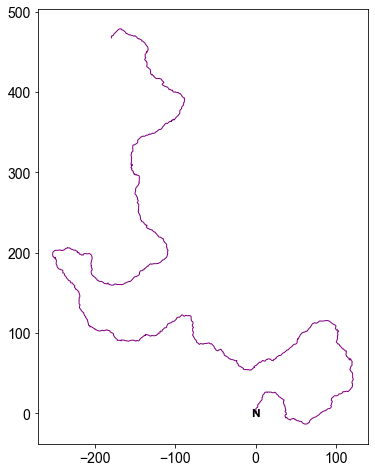

In [399]:
f = plt.figure(figsize=(8,8))
plt.axis([-map_size,map_size,-map_size,map_size])
plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
plt.plot(bee_coords[:T_outbound,0], bee_coords[:T_outbound,1], color='purple', lw=1)
plt.axis('scaled')
plt.show()

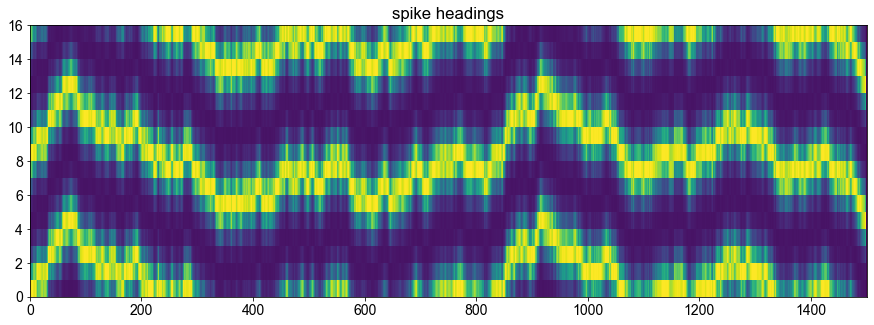

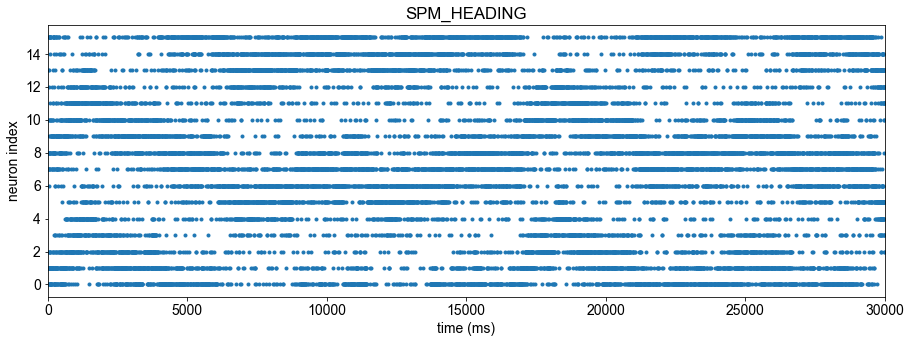

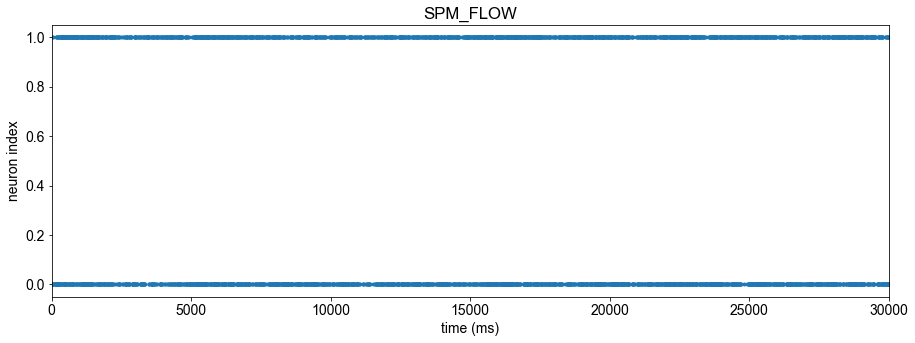

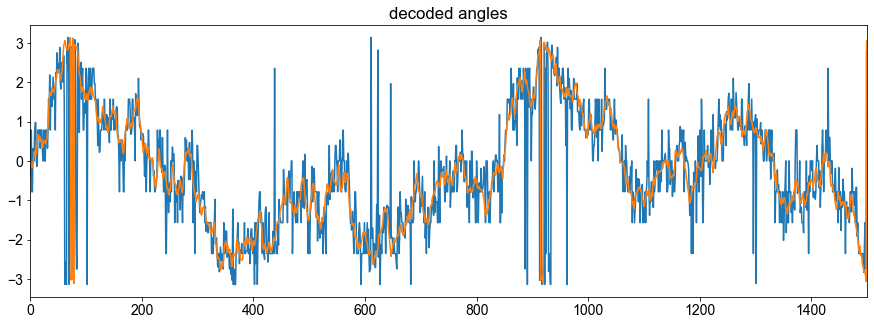

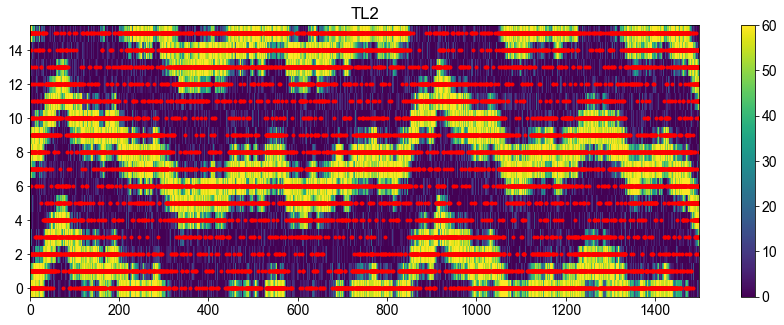

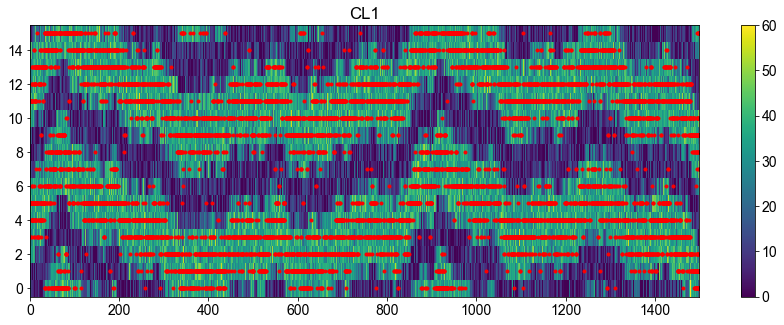

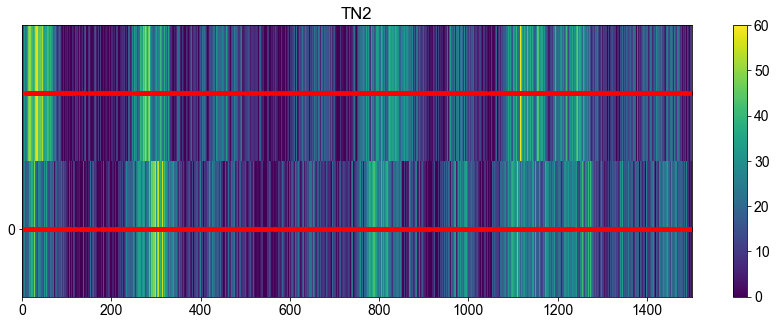

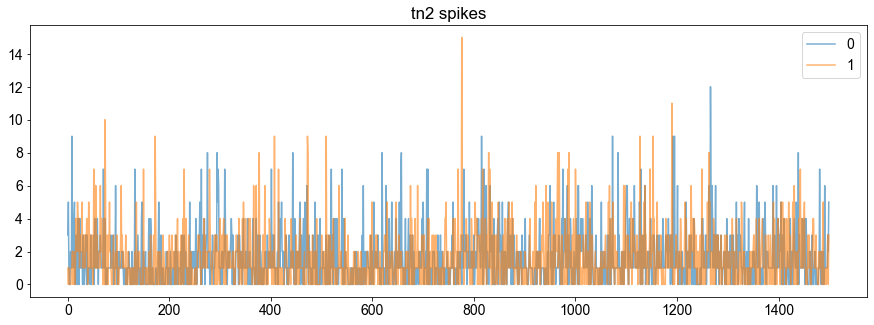

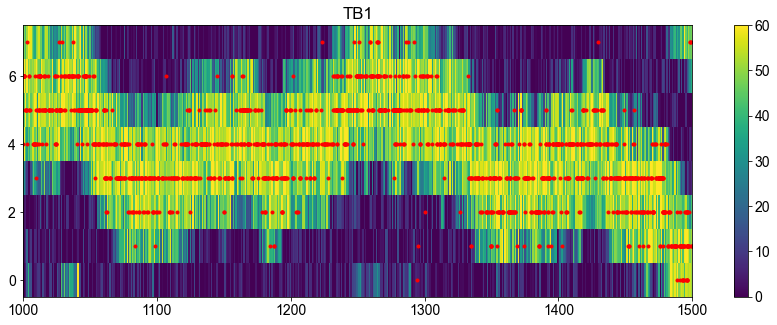

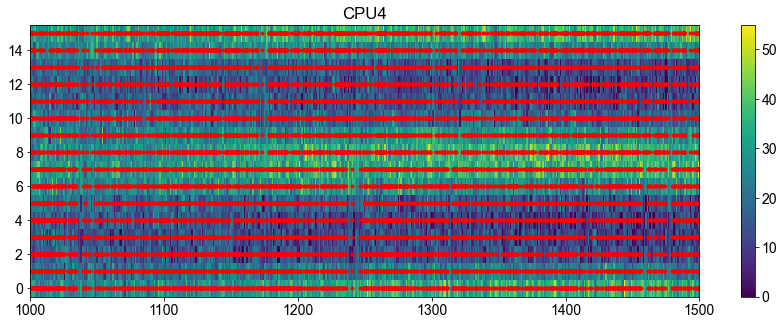

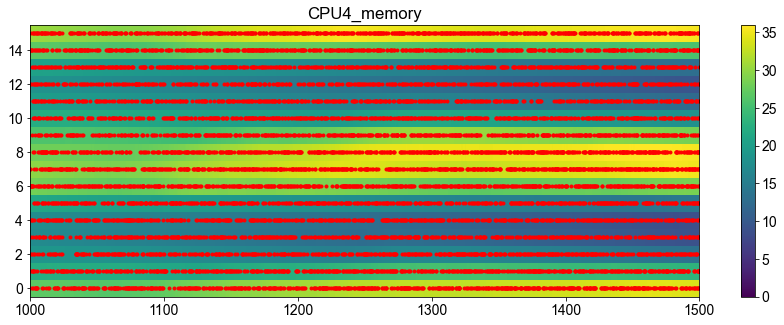

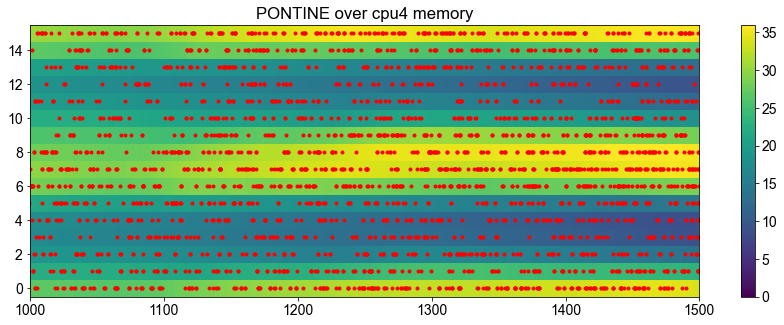

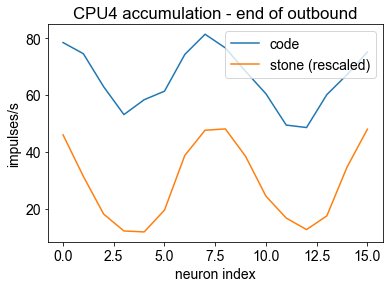

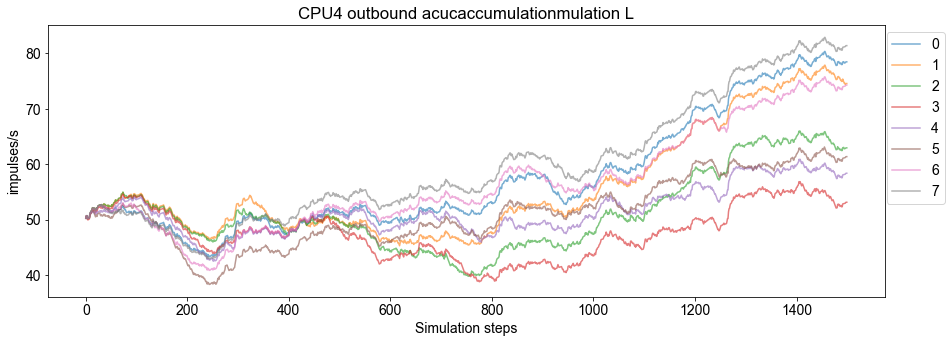

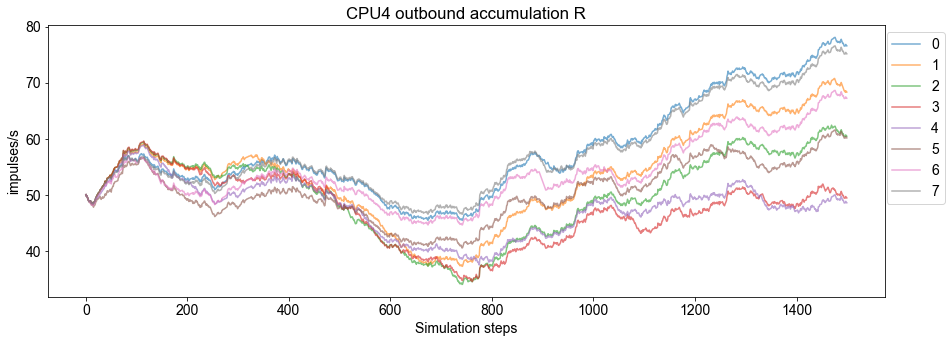

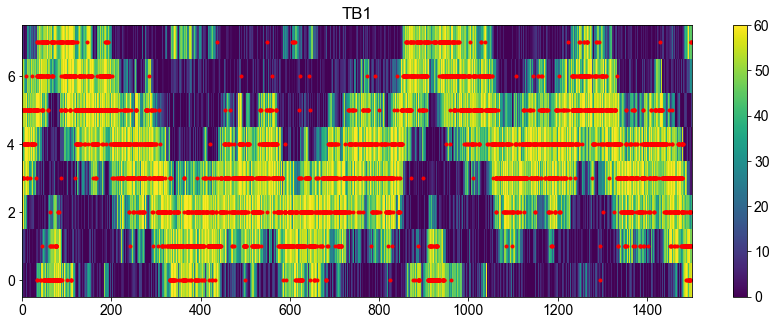

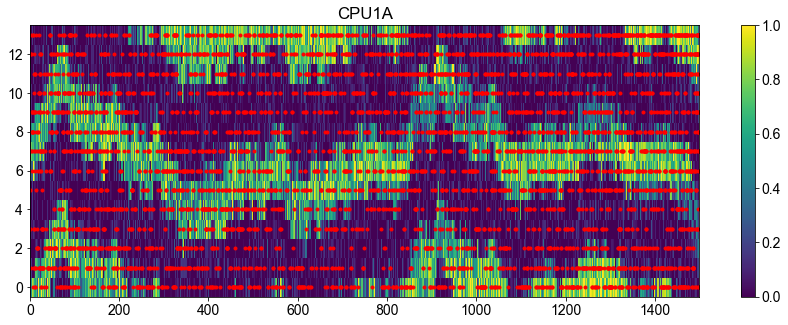

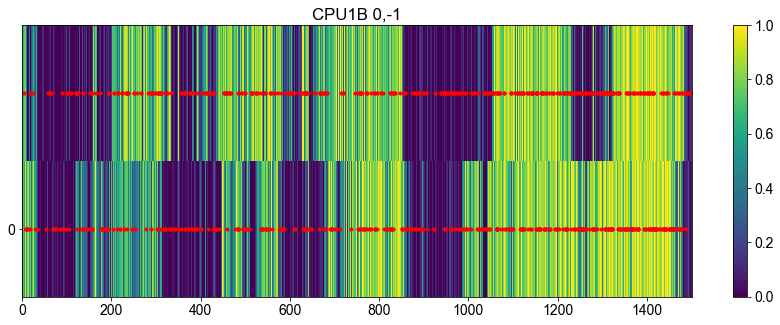

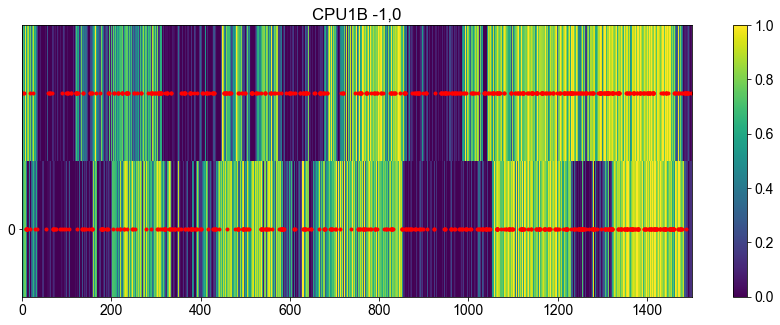

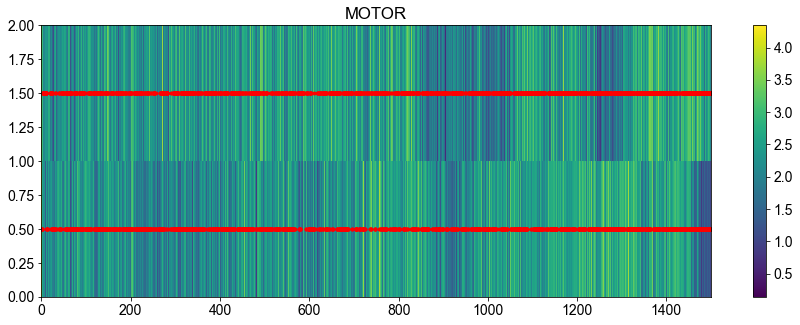

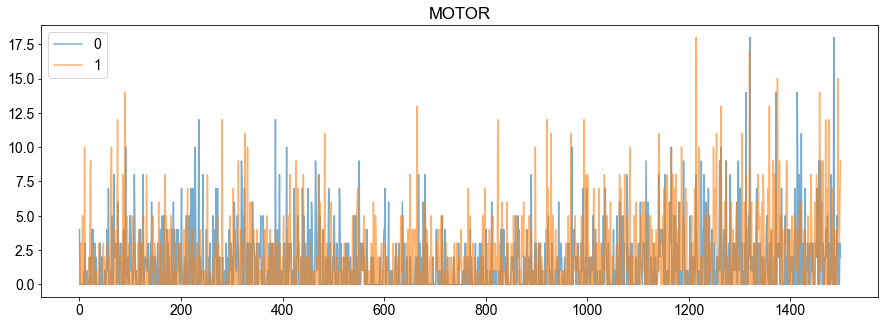

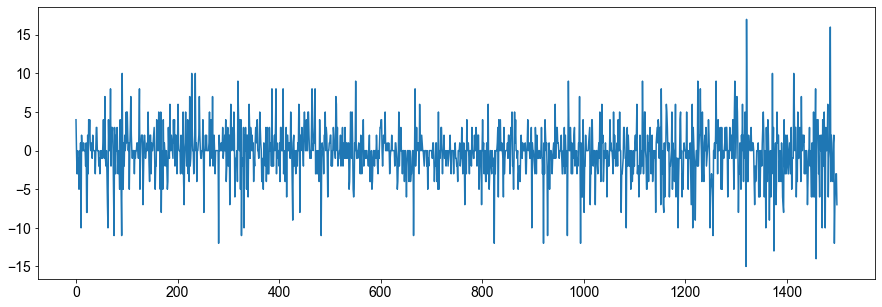

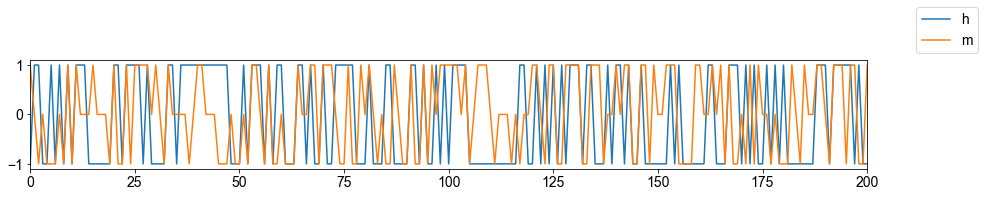

In [400]:
plt.figure(figsize=(15,5))
plt.pcolormesh(headings_hz.T/Hz)
plt.xlim([0,T_outbound])
plt.title('spike headings')
plt.show()

plt.figure(figsize=(15,5))
brian_plot(SPM_HEADING)
plt.xlim([0,T_outbound*time_step])
plt.title('SPM_HEADING')
plt.show()
plt.figure(figsize=(15,5))
brian_plot(SPM_FLOW)
plt.xlim([0,T_outbound*time_step])
plt.title('SPM_FLOW')
plt.show()


plt.figure(figsize=(15,5))
plt.plot(heading_angles)
plt.plot(h)
plt.xlim([0,T_outbound])
plt.title('decoded angles')
plt.show()


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tl2, 60, SPM_TL2, time_step, 
                                            title='TL2',  figsize=(15,5), xlim=[0,T_outbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cl1, 60, SPM_CL1, time_step, 
                                            title='CL1',  figsize=(15,5), xlim=[0,T_outbound])


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tn2, 60, SPM_TN2, time_step, 
                                            title='TN2',  figsize=(15,5), xlim=[0,T_outbound])
TN2_spikes =  cx_spiking.inputs.get_spikes_rates(SPM_TN2, N_TN2, T_outbound, time_step)
plt.figure(figsize=(15,5))
plt.title('TN2 spikes')
for idx, r in enumerate(TN2_spikes):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.title('tn2 spikes')
plt.show()



cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tb1, 60, SPM_TB1, time_step, 
                                            title='TB1',  figsize=(15,5), xlim=[T_outbound-500,T_outbound])


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu4, 60, SPM_CPU4, time_step, 
                                            title='CPU4',  figsize=(15,5), xlim=[T_outbound-500,T_outbound])


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.memory, 60, SPM_CPU4_MEMORY, time_step, 
                                            title='CPU4_memory',  figsize=(15,5), xlim=[T_outbound-500,T_outbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.memory, 60, SPM_PONTINE, time_step, 
                                            title='PONTINE over cpu4 memory',  figsize=(15,5), xlim=[T_outbound-500,T_outbound])




plt.plot(CPU4_memory_history[T_outbound-1], label='code')
plt.plot(cx_log.memory[:,T_outbound-1]*CPU4_memory.max(), label='stone (rescaled)')
plt.legend()
plt.xlabel('neuron index')
plt.ylabel('impulses/s')
plt.title('CPU4 accumulation - end of outbound')
plt.show()

plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(CPU4_memory_history[:T_outbound,r], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
#plt.xlim([1400,1500])
plt.title('CPU4 outbound acucaccumulationmulation L')
plt.ylabel('impulses/s')
plt.xlabel('Simulation steps')
plt.show()
plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(CPU4_memory_history[:T_outbound,r+8], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
#plt.xlim([1400,1500])
plt.title('CPU4 outbound accumulation R')
plt.ylabel('impulses/s')
plt.xlabel('Simulation steps')
plt.show()


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tb1, 60, SPM_TB1, time_step, 
                                            title='TB1',  figsize=(15,5), xlim=[0,T_outbound])


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[1:-1,:], 1, SPM_CPU1A, time_step,
                                            title='CPU1A',  figsize=(15,5), xlim=[0,T_outbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[[0,-1],:], 1, SPM_CPU1B, time_step, 
                                            title='CPU1B 0,-1',  figsize=(15,5), xlim=[0,T_outbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[[-1,0],:], 1, SPM_CPU1B, time_step, 
                                            title='CPU1B -1,0',  figsize=(15,5), xlim=[0,T_outbound])


motors = cx_spiking.inputs.compute_motors(cx_log.cpu1)
cx_spiking.plotting.plot_motors_cx_log_spikes(motors, motors.max(), SPM_MOTOR, time_step, min_rate=motors.min(), 
                                            title='MOTOR',  figsize=(15,5), xlim=[0,T_outbound])
MOTOR_spikes =  cx_spiking.inputs.get_spikes_rates(SPM_MOTOR, N_MOTOR, T_outbound, time_step)
plt.figure(figsize=(15,5))
plt.title('MOTOR')
for idx, r in enumerate(MOTOR_spikes):
    plt.plot(r, alpha=0.6, label=idx)
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.plot((MOTOR_spikes[0,:]-MOTOR_spikes[1,:]))
plt.show()


plt.figure(figsize=(15,2))
#plt.plot(headings_diff)
plt.plot(np.sign(motors[0,:]-motors[1,:]), label='h')
plt.plot(np.sign((MOTOR_spikes[0,:]-MOTOR_spikes[1,:])), label='m')
plt.xlim([0,200])
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Inbound path

In [404]:
%%time
net.restore('outbound')

net['update_inputs'].active = True
net['CPU4_accumulator'].active = False
net['CPU4_accumulator_inbound'].active = True

timestep = get_agent_timestep(net.t, time_step)

bee_coords[T_outbound:,] = np.nan

steps = 750
net.run((steps)*time_step*ms, report='text')

Starting simulation at t=30. s for a duration of 15. s
2.2183 s (14%) simulated in 10s, estimated 58s remaining.
4.1779 s (27%) simulated in 20s, estimated 52s remaining.
6.0464 s (40%) simulated in 30s, estimated 44s remaining.
8.2722 s (55%) simulated in 40s, estimated 33s remaining.
10.244 s (68%) simulated in 50s, estimated 23s remaining.
12.5203 s (83%) simulated in 1m 0s, estimated 12s remaining.
14.4525 s (96%) simulated in 1m 10s, estimated 3s remaining.
15. s (100%) simulated in 1m 13s
CPU times: user 1min 12s, sys: 268 ms, total: 1min 13s
Wall time: 1min 13s


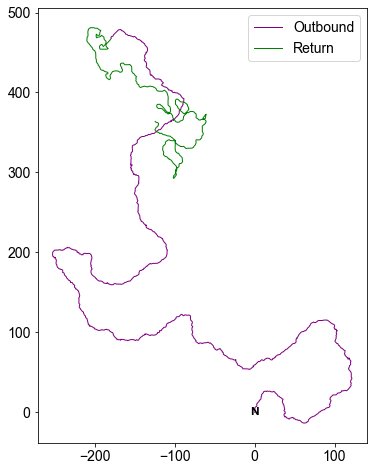

In [405]:
f = plt.figure(figsize=(8,8))
plt.axis([-map_size,map_size,-map_size,map_size])
plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
plt.plot(bee_coords[:T_outbound,0], bee_coords[:T_outbound,1], color='purple', lw=1, label='Outbound')
plt.plot(bee_coords[T_outbound:,0], bee_coords[T_outbound:,1], color='green', lw=1, label='Return')
plt.axis('scaled')
plt.legend()
plt.show()

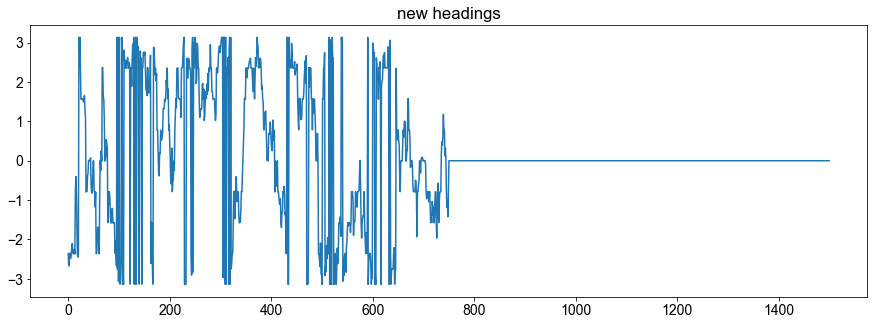

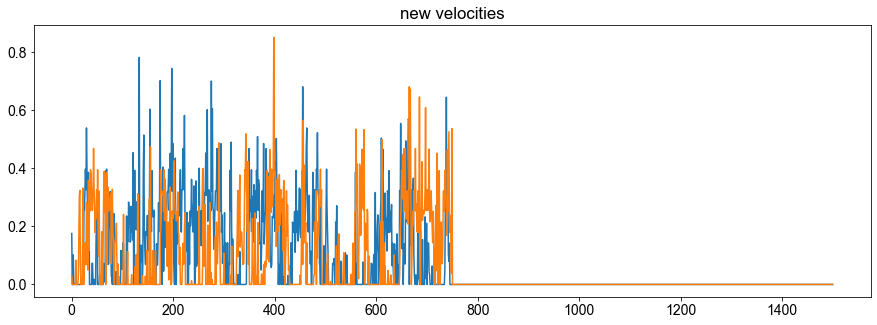

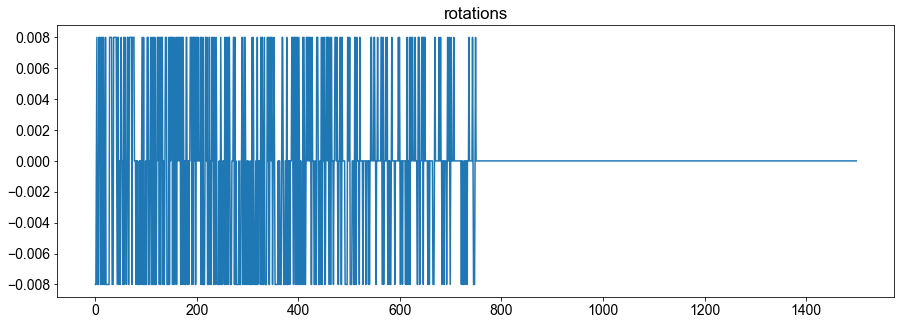

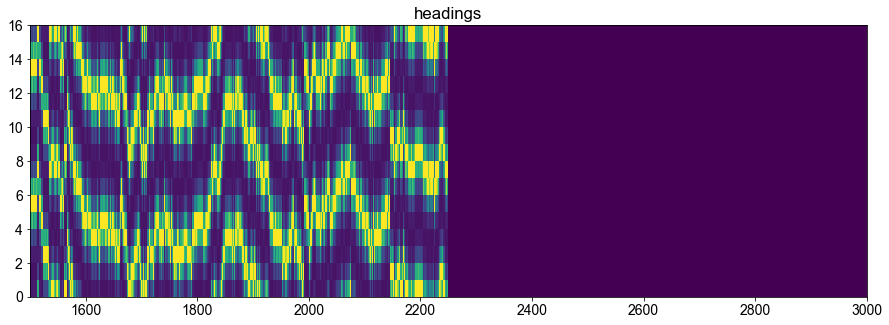

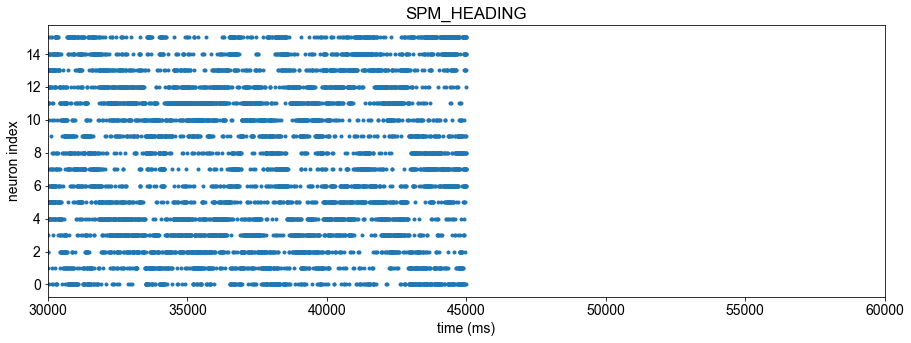

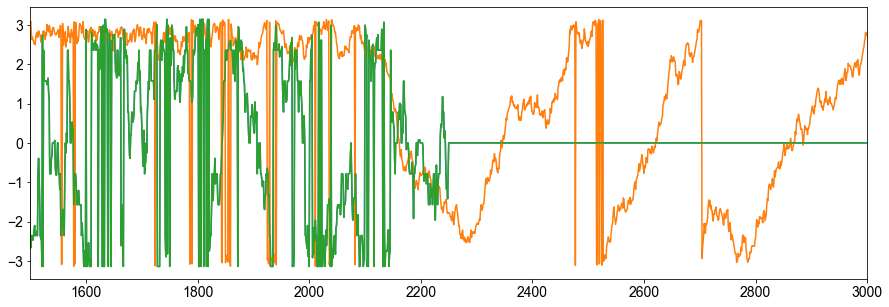

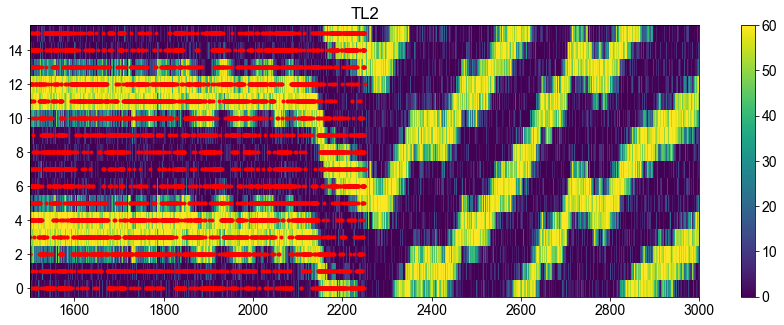

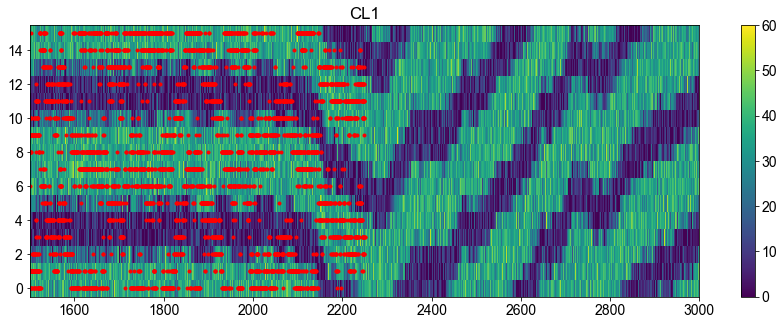

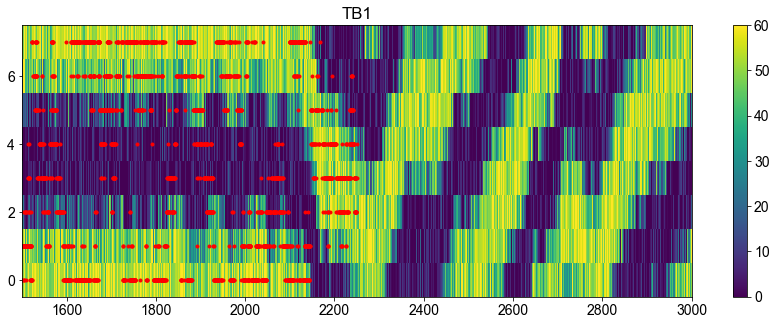

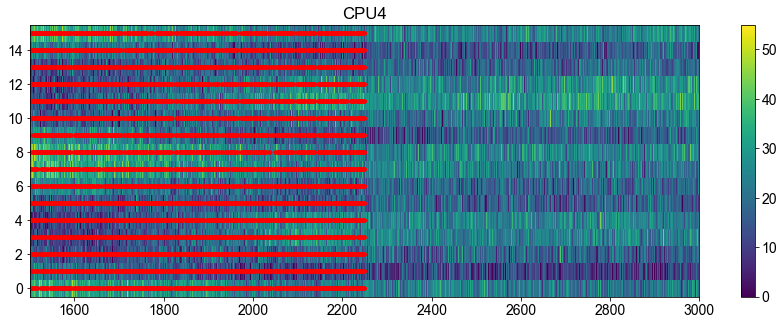

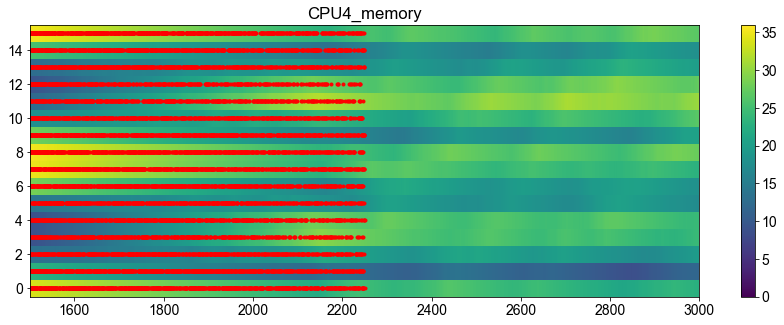

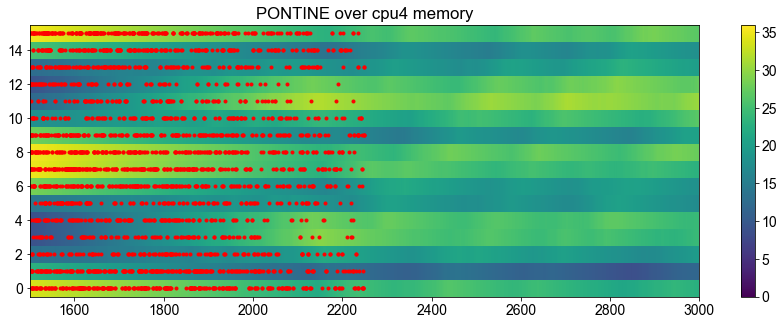

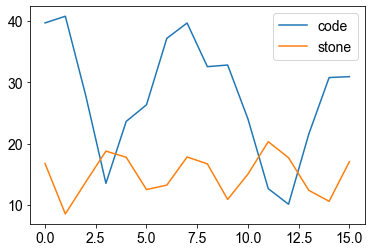

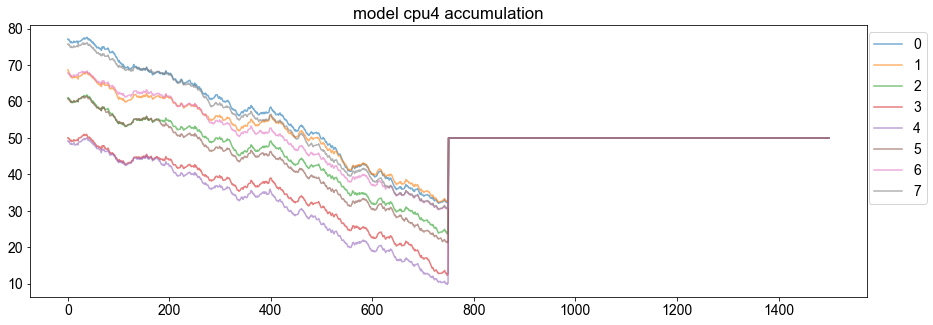

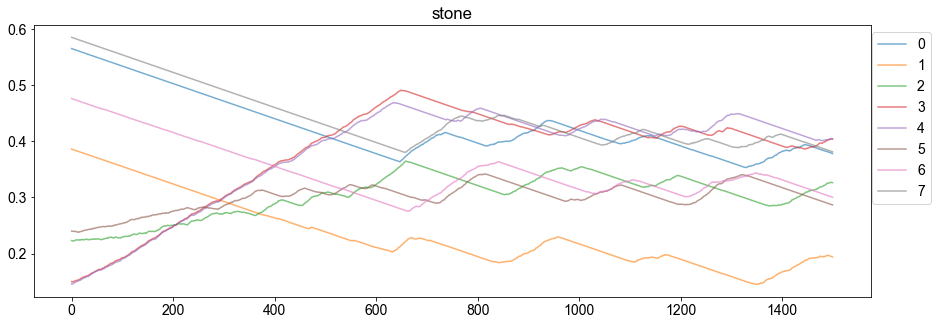

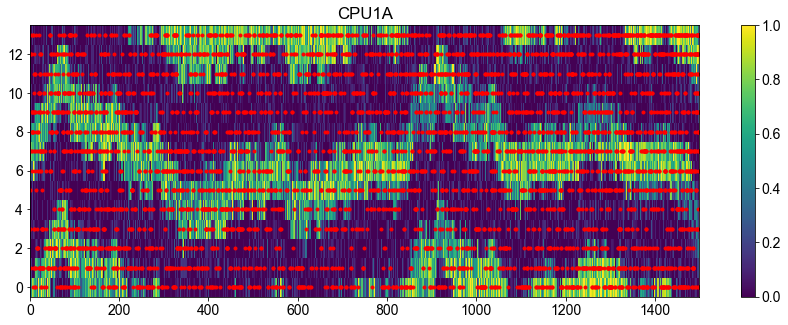

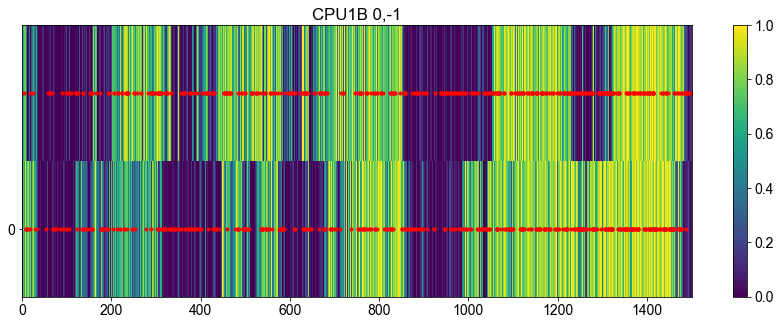

In [406]:
plt.figure(figsize=(15,5))
plt.plot(new_heading_dir[T_outbound:])
plt.title('new headings')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(new_velocities[T_outbound:])
plt.title('new velocities')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(rotations[T_outbound:])
plt.title('rotations')
plt.show()



plt.figure(figsize=(15,5))
plt.pcolormesh(headings_hz.T/Hz)
plt.xlim([T_outbound,T_outbound+T_inbound])
plt.title('headings')
plt.show()

plt.figure(figsize=(15,5))
brian_plot(SPM_HEADING)
plt.xlim([T_outbound*time_step,(T_outbound+T_inbound)*time_step])
plt.title('SPM_HEADING')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(heading_angles)
plt.plot(h)
plt.xlim([T_outbound,T_outbound+T_inbound])
plt.plot(heading_angles)
plt.show()


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tl2, 60, SPM_TL2, time_step, 
                                            title='TL2',  figsize=(15,5), xlim=[T_outbound,T_outbound+T_inbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cl1, 60, SPM_CL1, time_step, 
                                            title='CL1',  figsize=(15,5), xlim=[T_outbound,T_outbound+T_inbound])


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.tb1, 60, SPM_TB1, time_step, 
                                            title='TB1',  figsize=(15,5), xlim=[T_outbound,T_outbound+T_inbound])


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu4, 60, SPM_CPU4, time_step, 
                                            title='CPU4',  figsize=(15,5), xlim=[T_outbound,T_outbound+T_inbound])


cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.memory, 60, SPM_CPU4_MEMORY, time_step, 
                                            title='CPU4_memory',  figsize=(15,5), xlim=[T_outbound,T_outbound+T_inbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.memory, 60, SPM_PONTINE, time_step, 
                                            title='PONTINE over cpu4 memory',  figsize=(15,5), xlim=[T_outbound,T_outbound+T_inbound])


plt.plot(CPU4_memory_history[T_outbound+steps-1,:], label='code')
plt.plot(cx_log.memory[:,T_outbound+steps]*CPU4_memory.max(), label='stone')
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(CPU4_memory_history[T_outbound:,r+8], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
plt.title('model cpu4 accumulation')
#plt.xlim([1400,1500])
plt.show()

plt.figure(figsize=(15,5))
ranges = range(CPU4_memory_history.shape[1]//2)
for r in ranges:
    plt.plot(cx_log.memory[r,T_outbound:], alpha=0.6, label=r)#, label=names[idx])
plt.legend(bbox_to_anchor=(1.08, 1))
plt.title('stone')
#plt.xlim([1400,1500])
plt.show()




cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[1:-1,:], 1, SPM_CPU1A, time_step,
                                            title='CPU1A',  figsize=(15,5), xlim=[0,T_outbound])

cx_spiking.plotting.plot_rate_cx_log_spikes(cx_log.cpu1[[0,-1],:], 1, SPM_CPU1B, time_step, 
                                            title='CPU1B 0,-1',  figsize=(15,5), xlim=[0,T_outbound])



0.0032124351435807146 0.001718886331812497 0.12175574581133974
0.3746932423036705 -0.48732408881460765


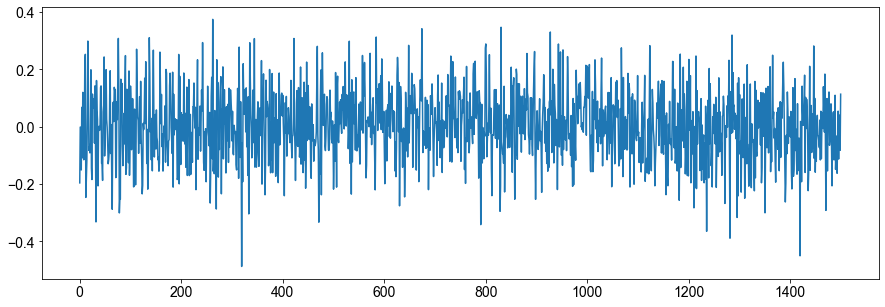

In [142]:
# Motor output from Stone
rotation_angles_rates = cx_log.motor[T_outbound:]
plt.figure(figsize=(15,5))
plt.plot(rotation_angles_rates)

print(np.mean(rotation_angles_rates), np.median(rotation_angles_rates), np.std(rotation_angles_rates))
print(np.max(rotation_angles_rates), np.min(rotation_angles_rates))

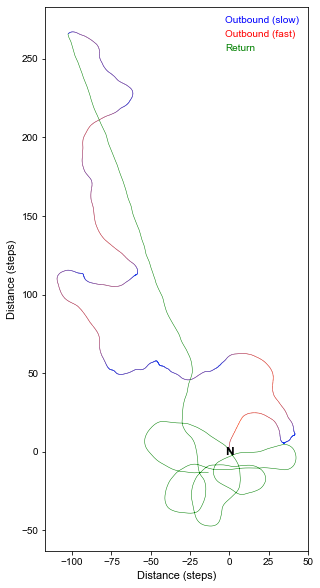

In [263]:
#plt.figure(figsize=(10,5))
plotter.plot_route(h, v, T_outbound, T_inbound, plot_speed=True, figsize=(15,10))
plt.show()

In [247]:
%%time
#net = Network(collect())
#net.run((T_outbound)*time_step*ms, report='text')

for ts in range(T_outbound):
    if ts % 100 == 0:
        print(f'{ts+1}/{T_outbound}')
    #P_HEADING.rates = headings_hz[ts,:]
    #P_FLOW.rates = flow_hz[ts,:]
    #P_CPU4_MEMORY.rates = CPU4_memory_stimulus[ts,:]

    #net.run(time_step*ms)


#net.store('outbound')

1/1500
101/1500
201/1500
301/1500
401/1500
501/1500
601/1500
701/1500
801/1500
901/1500
1001/1500
1101/1500
1201/1500
1301/1500
1401/1500
CPU times: user 15min 5s, sys: 24.7 s, total: 15min 30s
Wall time: 16min 3s


0


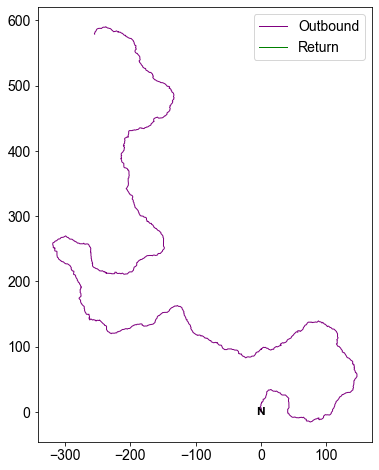

in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
50


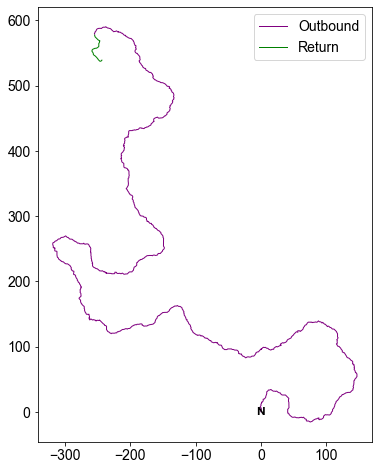

in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
100


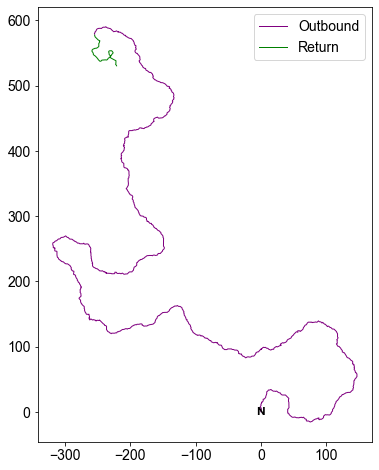

in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
150


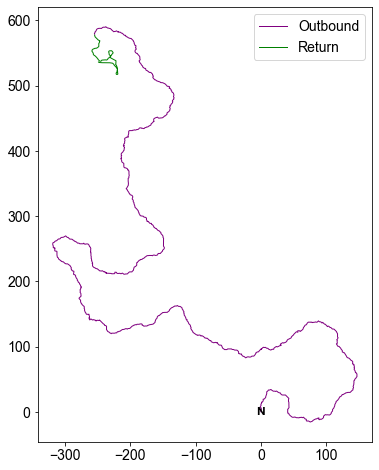

in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
in here
CPU times: user 2min 20s, sys: 4.56 s, total: 2min 24s
Wall time: 2min 43s


In [56]:
%%time
net.restore('outbound')
net['update_inputs'].active = True

timestep = get_agent_timestep(net.t, time_step)

bee_coords[T_outbound:,] = np.nan

new_heading_dir = np.zeros(T_inbound)
new_velocities = np.zeros((T_inbound,2))
#G_MOTOR.spike_count = extract_spike_counts(SPM_MOTOR, (sim_timestep)*time_step*ms, time_step)

#P_HEADING.rates = headings_hz[T_outbound,:]
#P_FLOW.rates = flow_hz[T_outbound,:]
#P_CPU4_MEMORY.rates = CPU4_memory_stimulus[T_outbound,:]


for ts in range(200):
    if ts % 50 == 0:
        print(ts)
        f = plt.figure(figsize=(8,8))
        plt.axis([-map_size,map_size,-map_size,map_size])
        plt.text(0, 0, 'N', fontsize=12, fontweight='heavy', color='k', ha='center', va='center')
        plt.plot(bee_coords[:T_outbound,0], bee_coords[:T_outbound,1], color='purple', lw=1, label='Outbound')
        plt.plot(bee_coords[T_outbound:,0], bee_coords[T_outbound:,1], color='green', lw=1, label='Return')
        plt.axis('scaled')
        plt.legend()
        plt.show()
    sim_timestep = T_outbound+ts
    #print(sim_timestep)
    #print(sim_timestep)
    # prepare inputs
    
    #### motor response - rotation
    #print(extract_spike_counts(SPM_MOTOR, (sim_timestep)*time_step*ms, time_step), G_MOTOR.spike_count)
    #motor_responses = G_MOTOR.spike_count
    #rotation = np.sign(motor_responses[0] - motor_responses[1])
    #print(motor_responses, rotation)
    #G_MOTOR.spike_count = 0
    
    #### heading
    ## previous heading
    #prev_heading = np.array([heading_angles[sim_timestep-1]])
    # compute spikes based on old heading and rotation using fixed angle "step" of 22.5 degrees 
    #new_heading = prev_heading + rotation * 0.008 # mean and median rotation found from rate model
    #new_heading_dir[ts] = new_heading
    #new_headings = cx_spiking.inputs.compute_headings(new_heading, N=N_TL2//2, vmin=5, vmax=100)
    #new_headings = np.tile(new_headings, 2) 
    # save new heading
    #headings_hz[sim_timestep,:] = new_headings * Hz

    
    #### velocity
    #velocity = np.array(velocities[sim_timestep-1,:])
    #updated_v = get_next_velocity(new_heading, velocity, rotation)
    #new_velocities[ts,:] = updated_v
    #new_flow = cx_spiking.inputs.compute_flow(new_heading, updated_v, baseline=50, 
    #                                          vmin=0, vmax=50, inbound=True)
    #flow_hz[sim_timestep,:] = new_flow * Hz

  
    # Run network 
    net.run(time_step*ms)

    
    # Update for next iteration
    #if ts == T_inbound-1:
    #    break
    #P_HEADING.rates = headings_hz[sim_timestep+1,:]
    #P_FLOW.rates = flow_hz[sim_timestep+1,:]
    #P_CPU4_MEMORY.rates = CPU4_memory_stimulus[sim_timestep,:]

    # run newtork for a single timestep
    #net.run(time_step*ms)